In [962]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math
import os
import glob
from sklearn import datasets, linear_model
from regression import lin_reg_model, k_fold_cross_validation
from sklearn.feature_selection import SelectFromModel, f_regression, SelectKBest
import xgboost as xg
from sklearn.tree import DecisionTreeRegressor  

pd.set_option('display.max_columns', None)

### Агрегация CSV файлов

Для начала отметим, что для изучения мы взяли датасет о перелетах из штата Айова в 2019 году.

Мы решили взять следующие колонки из датасета:
- YEAR
- QUARTER
- MONTH
- DAY_OF_MONTH
- DAY_OF_WEEK
- OP_UNIQUE_CARRIER
- ORIGIN_AIRPORT_ID
- DEST_AIRPORT_ID
- DEST_STATE_NM
- CRS_DEP_TIME
- DEP_DELAY
- DISTANCE

Дополнительно ради интереса решили включить данные о погоде в штате Айова из внешнего источника. Почему бы и нет? 

Из погодных данных:
- Precipitation - кол-во осадков
- Wind Speed - скорость ветра
- Visibility - видимость
- Snow Depth - глубина снежного покрова

In [1298]:
DATA_DIR = "/home/denis/Godis/Projects/IS-Tasks/data/"
dfs = [pd.read_csv(file) for file in glob.glob(f"{DATA_DIR}/97570672_T_ONTIME_REPORTING (*).csv")]
original_df = pd.concat(dfs, ignore_index=True)

df_w = pd.read_csv(f"{DATA_DIR}/iowa_weather.csv")
df_w["Date time"] = pd.to_datetime(df_w["Date time"], format="%m/%d/%Y")

In [1055]:
original_df

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_NM,DEST_AIRPORT_ID,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,Unnamed: 18
0,2019,2,5,19,7,9E,N314PQ,3355,11423,DSM,Iowa,13487,"Minneapolis, MN",Minnesota,654,-4.0,76.0,232.0,NaN
1,2019,2,5,18,6,9E,N538CA,3361,12953,LGA,New York,11423,"Des Moines, IA",Iowa,1030,-7.0,185.0,1031.0,NaN
2,2019,2,5,19,7,9E,N325PQ,3369,11423,DSM,Iowa,12953,"New York, NY",New York,1325,46.0,161.0,1031.0,NaN
3,2019,2,5,11,6,9E,N909XJ,3390,12953,LGA,New York,11423,"Des Moines, IA",Iowa,1030,-6.0,185.0,1031.0,NaN
4,2019,2,5,12,7,9E,N279PQ,3399,11423,DSM,Iowa,13487,"Minneapolis, MN",Minnesota,809,-6.0,76.0,232.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59056,2019,4,12,13,5,MQ,N222NS,4238,11298,DFW,Texas,11003,"Cedar Rapids/Iowa City, IA",Iowa,852,-4.0,126.0,685.0,NaN
59057,2019,4,12,14,6,MQ,N220NN,4238,11298,DFW,Texas,11003,"Cedar Rapids/Iowa City, IA",Iowa,852,-5.0,126.0,685.0,NaN
59058,2019,4,12,15,7,MQ,N233NN,4238,11298,DFW,Texas,11003,"Cedar Rapids/Iowa City, IA",Iowa,852,-3.0,126.0,685.0,NaN
59059,2019,4,12,16,1,MQ,N256NN,4238,11298,DFW,Texas,11003,"Cedar Rapids/Iowa City, IA",Iowa,852,0.0,126.0,685.0,NaN


### Первичная фильтрация данных

In [1238]:
df = original_df[[
 'QUARTER',
 'MONTH',
 'DAY_OF_MONTH',
 'DAY_OF_WEEK',
 'ORIGIN_AIRPORT_ID',
 'OP_UNIQUE_CARRIER',
 'DEST_AIRPORT_ID',
 'ORIGIN_STATE_NM',
 'DEST_AIRPORT_ID',
 'DEST_STATE_NM',
 'CRS_DEP_TIME',
 'DEP_DELAY',
 'DISTANCE'
]]

# Выбираем только один штат
df = df[df.ORIGIN_STATE_NM == 'Iowa']
df = df.dropna()

# Конвертируем время hhmm в минуты
time = df['CRS_DEP_TIME'].copy()
df['CRS_DEP_TIME'] = time % 100 + 60 * (time // 100)
df['CRS_DEP_HOUR'] = time // 100

df["DATE"] = pd.to_datetime(pd.DataFrame({
    "year": 2019,
    "month": df["MONTH"],
    "day": df["DAY_OF_MONTH"]
}))

In [1239]:
df = df.join(
    df_w.set_index("Date time")[["Precipitation", "Wind Speed", "Visibility", "Snow Depth", "Temperature"]],
    on="DATE"
)
df["Snow Depth"] = df["Snow Depth"].fillna(0)

In [1240]:
X = df.drop(columns=["DEP_DELAY", "ORIGIN_STATE_NM"])
y = df["DEP_DELAY"]

## Изучение данных

In [1241]:
df.head()

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN_AIRPORT_ID,OP_UNIQUE_CARRIER,DEST_AIRPORT_ID,ORIGIN_STATE_NM,DEST_AIRPORT_ID,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY,DISTANCE,CRS_DEP_HOUR,DATE,Precipitation,Wind Speed,Visibility,Snow Depth,Temperature
0,2,5,19,7,11423,9E,13487,Iowa,13487,Minnesota,414,-4.0,232.0,6,2019-05-19,3.8,33.5,15.1,0.0,13.2
2,2,5,19,7,11423,9E,12953,Iowa,12953,New York,805,46.0,1031.0,13,2019-05-19,3.8,33.5,15.1,0.0,13.2
4,2,5,12,7,11423,9E,13487,Iowa,13487,Minnesota,489,-6.0,232.0,8,2019-05-12,3.1,13.0,15.4,0.0,8.8
32,2,5,27,1,11423,9E,13487,Iowa,13487,Minnesota,656,-7.0,232.0,10,2019-05-27,7.6,35.3,15.7,0.0,21.2
34,2,5,4,6,11423,9E,11433,Iowa,11433,Michigan,510,-10.0,534.0,8,2019-05-04,0.0,14.8,16.0,0.0,13.2


### Числовые признаки

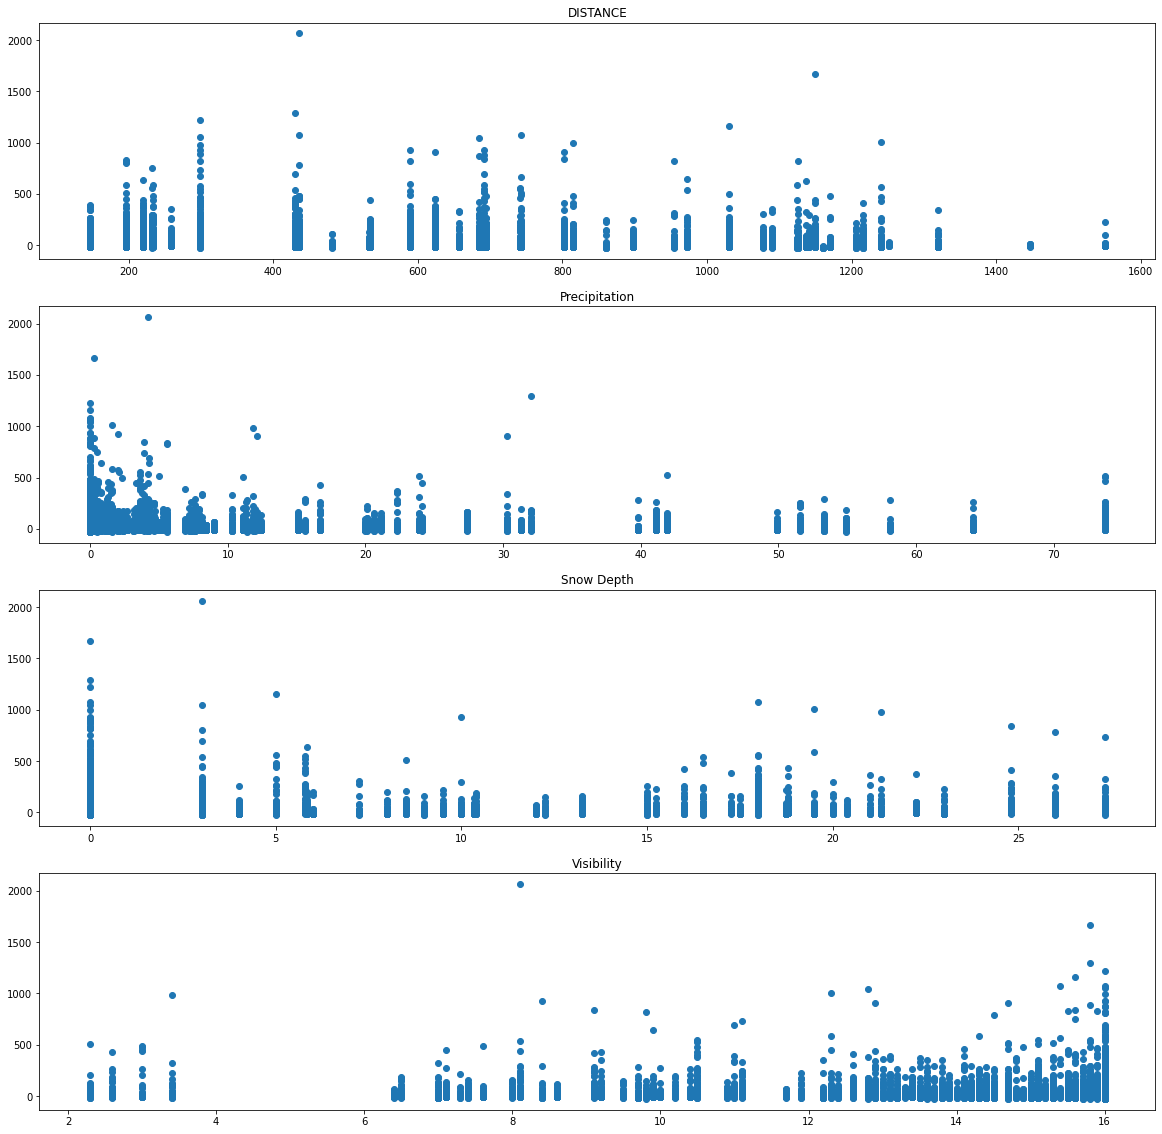

In [1242]:
numerical = ["DISTANCE", "Precipitation", "Snow Depth", "Visibility"]
fig, axs = plt.subplots(len(numerical), figsize=(20, 20))
for i in range(len(numerical)):
    col_name = numerical[i]
    x_i = X[col_name]
    axs[i].scatter(x_i, y)
    axs[i].set_title(col_name)

Протяженность маршрута, видимо, соответствуют направлениям полета - видно, что уникальных дальностей полета не так уж много. Визуально не видно какой-то зависимости между дальностью полета и временем задержки, чтобы это можно было использовать для лин. регрессии.

### Как распределены числовые признаки:

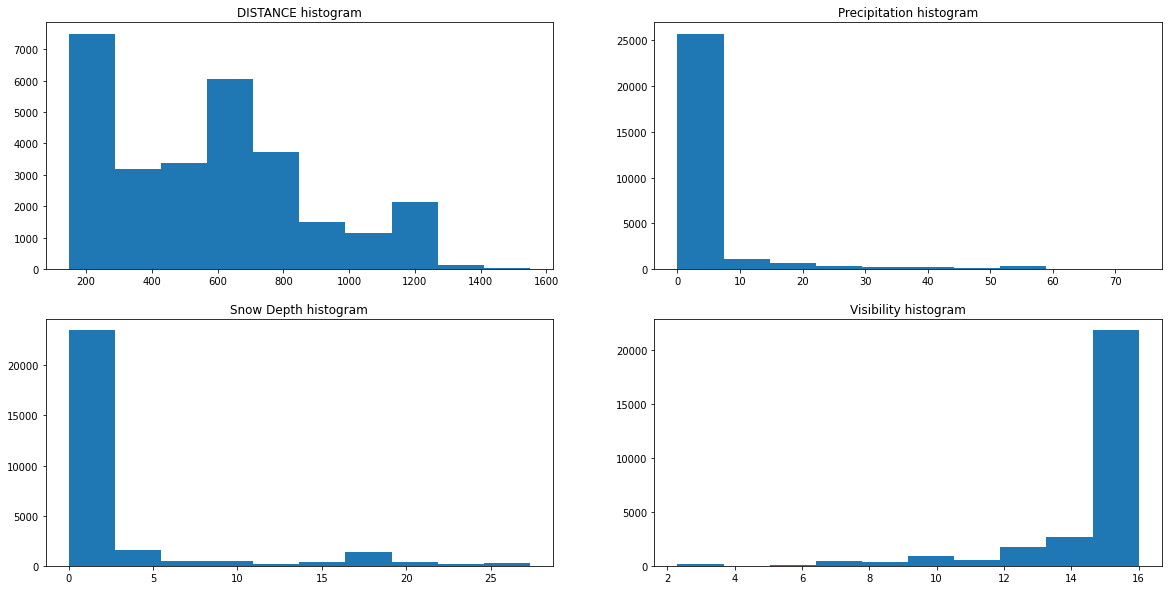

In [1243]:
fig, axs = plt.subplots(len(numerical) // 2, 2, figsize=(20, 10))
for i in range(len(numerical)):
    col_name = numerical[i]
    x_i = X[col_name]
    axs[i//2,i%2].hist(x_i)
    axs[i//2,i%2].set_title(col_name + " histogram")

### Выводы

Протяженность маршрута, видимо, соответствуют направлениям полета - видно, что уникальных дальностей полета не так уж много. Визуально не видно какой-то зависимости между дальностью полета и временем задержки, чтобы это можно было использовать для лин. регрессии.

№Погодные признаки интуитивно должны хорошо влиять на время задержки и, возможно, так оно и есть. Из гистограмм видно, что в датасете большое количество дней без осадков (0) и с хорошей (16) видимостью. Такое распределение можно описать как "в большинство дней осадков нет и видимость хорошая". С другой стороны из графиков видно, что при хорошей и плохой видимости время задержки может быть как большим, так и маленьким. То есть из графиков уловить какую-нибудь полезную связь между погодными признаками и временем задержки не удается.

### Дополнительно

Попробуем проверить хотя бы предположение, что при плохой видимости, время задержки в среднем больше. Для этого разделим выборку на две равные части - в одной все наблюдения, при которых видимость меньше медианы, в другой - при которых больше.

In [1244]:
p_1 = X["Visibility"] >= X["Visibility"].mean()
p_2 = ~p_1

m_1 = Y[p_1].mean()
m_2 = Y[p_2].mean()

print(m_1, m_2)

6.128612716763006 20.75


Видно, что влияние видимости на целевую переменную в некоторой степени есть. Аналогично проверим для осадков, величины снежного покрова:

In [1248]:
p_1 = X["Precipitation"] >= X["Precipitation"].mean()
p_2 = ~p_1

m_1 = Y[p_1].mean()
m_2 = Y[p_2].mean()

print(m_1, m_2)

16.368098159509202 11.192700729927008


In [1249]:
p_1 = X["Snow Depth"] >= X["Snow Depth"].mean()
p_2 = ~p_1

m_1 = Y[p_1].mean()
m_2 = Y[p_2].mean()

print(m_1, m_2)

24.80780780780781 10.922022279348758


In [1247]:
p_1 = X["Wind Speed"] >= X["Wind Speed"].mean()
p_2 = ~p_1

m_1 = Y[p_1].mean()
m_2 = Y[p_2].mean()

print(m_1, m_2)

15.988031914893616 12.010695187165775


### Категориальные признаки

Здесь было бы интересно посмотреть, как связано среднее время задержки с каждой категорией. На графиках размер кружков показывает, насколько вообще данная категория часто встречается. Для удобства категории отсортированы по среднему значению целевой переменной

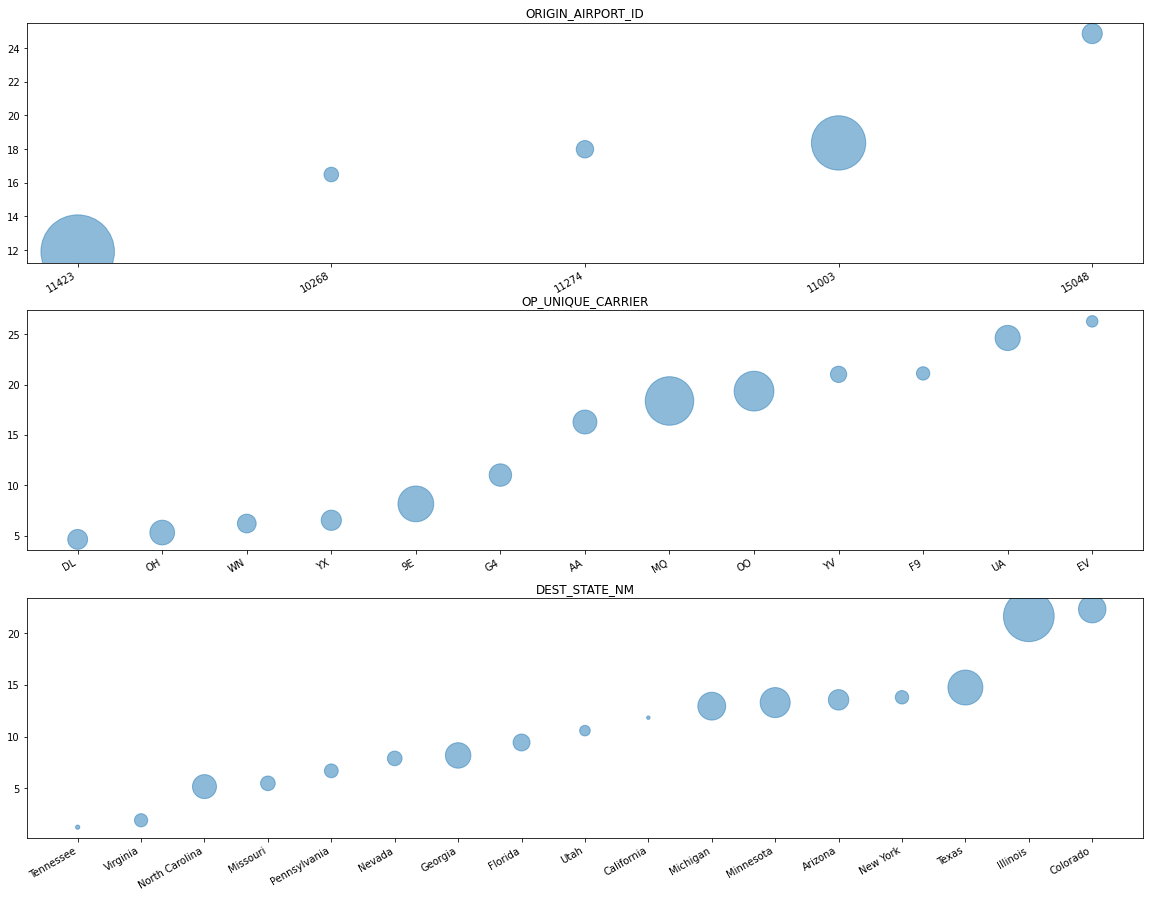

In [1220]:
categorial = ["ORIGIN_AIRPORT_ID", "OP_UNIQUE_CARRIER", "DEST_STATE_NM"]
fig, axs = plt.subplots(3, figsize=(20, 15))
for i in range(3):
    col_name = categorial[i]
    df_copy = df.copy()
    df_copy["COUNT"] = 1
    agg = df_copy.groupby(col_name).agg({
        "DEP_DELAY": "mean",
        "COUNT": "count"
    }).sort_values(by=["DEP_DELAY"])
    data = pd.DataFrame({
        "X": agg.index.astype("str"),
        "Y": agg["DEP_DELAY"],
        "bubble_size": agg["COUNT"]
    })
    axs[i].scatter('X', 'Y', s='bubble_size', data=data, alpha=0.5)
    axs[i].set_title(col_name)
    plt.setp(axs[i].get_xticklabels(), rotation=30, horizontalalignment='right')

### "Периодические" признаки

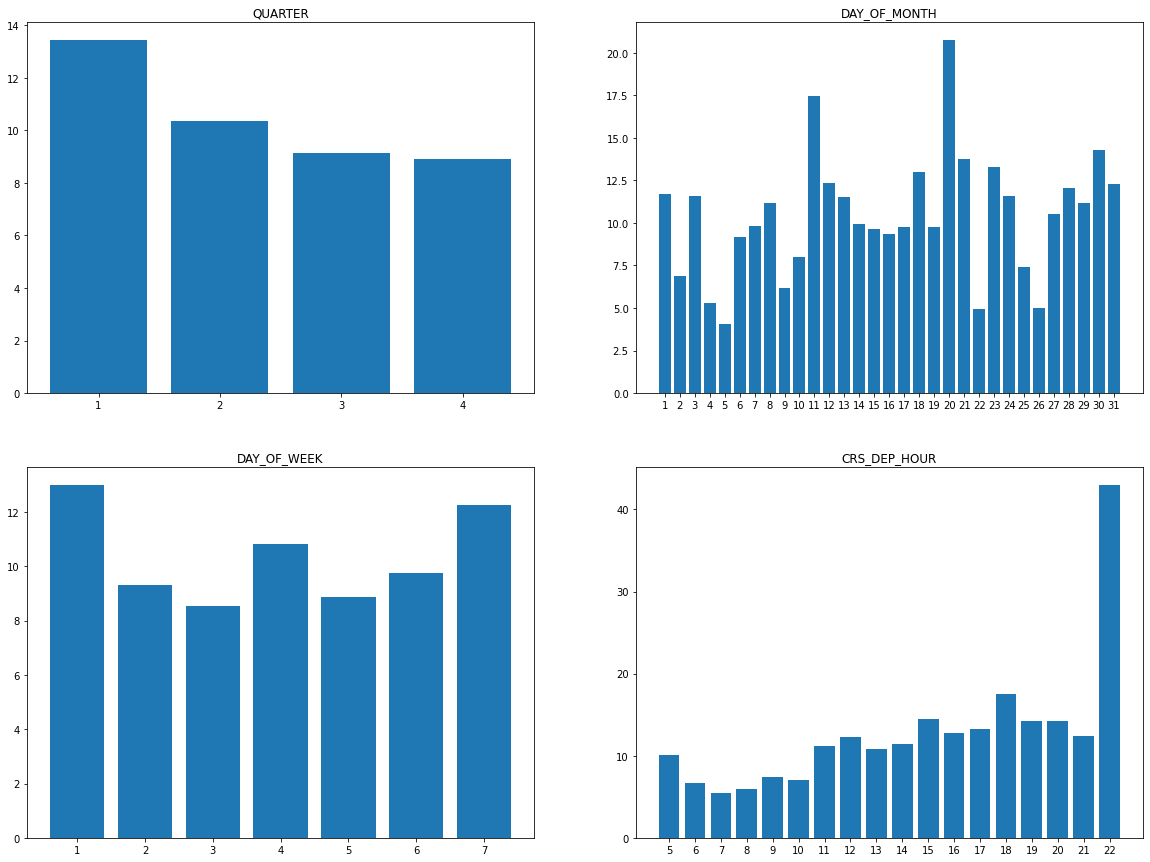

In [1250]:
periodical = ["QUARTER", "DAY_OF_MONTH", "DAY_OF_WEEK", "CRS_DEP_HOUR"]
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
for i in range(4):
    ax = axs[i//2, i%2]
    col_name = periodical[i]
    agg = df.groupby(col_name).agg("mean").sort_values(by=[col_name])
    ax.bar(agg.index.astype("str"), agg["DEP_DELAY"])
    ax.set_title(col_name)

## Подготовка данных

In [1255]:
prep_df = df.copy()

# берем первые 1500 строк и перемешиваем
prep_df = prep_df.sample(frac=1, random_state=1)[:1500]

# выбираем числовые признаки
prep_df = prep_df[[
 'CRS_DEP_TIME',
 'DEP_DELAY',
 'DISTANCE',
 'Precipitation',
 'Wind Speed',
 'Visibility',
 'Snow Depth'
]].dropna()

### One Hot Encoding

Здесь мы кодируем категориальные переменные. Заметим, что если переменная содержит N категорий, то мы добавляем N-1 столбец, так как N-ый будет линейно зависим с предыдущими.

In [1256]:
for_one_hot = ["QUARTER", "ORIGIN_AIRPORT_ID", "OP_UNIQUE_CARRIER", "DAY_OF_WEEK"]

for col_name in for_one_hot:
    unique_values = df[col_name].unique()
    for val in unique_values[:-1]:
        mask = df[col_name] == val
        new_col_name = f"{col_name}__{val}"
        prep_df[new_col_name] = 0
        prep_df.loc[mask, new_col_name] = 1
        
prep_df.head()

,CRS_DEP_TIME,DEP_DELAY,DISTANCE,Precipitation,Wind Speed,Visibility,Snow Depth,QUARTER__2,QUARTER__4,QUARTER__1,ORIGIN_AIRPORT_ID__11423,ORIGIN_AIRPORT_ID__11003,ORIGIN_AIRPORT_ID__15048,ORIGIN_AIRPORT_ID__10268,OP_UNIQUE_CARRIER__9E,OP_UNIQUE_CARRIER__DL,OP_UNIQUE_CARRIER__OO,OP_UNIQUE_CARRIER__YV,OP_UNIQUE_CARRIER__AA,OP_UNIQUE_CARRIER__UA,OP_UNIQUE_CARRIER__G4,OP_UNIQUE_CARRIER__MQ,OP_UNIQUE_CARRIER__F9,OP_UNIQUE_CARRIER__WN,OP_UNIQUE_CARRIER__YX,OP_UNIQUE_CARRIER__OH,DAY_OF_WEEK__7,DAY_OF_WEEK__1,DAY_OF_WEEK__6,DAY_OF_WEEK__2,DAY_OF_WEEK__3,DAY_OF_WEEK__4
20997,885,45.0,196.0,0.0,16.6,16.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
44183,365,6.0,802.0,2.3,16.6,15.9,0.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
42470,728,18.0,742.0,3.9,33.5,9.1,24.8,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
11991,840,-7.0,534.0,24.1,35.3,12.3,0.0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
56975,360,2.0,692.0,0.0,24.1,15.8,3.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [1275]:
X = prep_df.drop(columns=["DEP_DELAY"])
Y = prep_df["DEP_DELAY"]

### Нормализация

In [1276]:
X = X / X.aggregate("max")

### Проверка независимости признаков

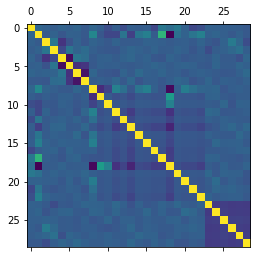

In [1281]:
plt.matshow(X.corr())
plt.show()

In [1282]:
X.corr()

,CRS_DEP_TIME,DISTANCE,Precipitation,Wind Speed,Visibility,Snow Depth,QUARTER__2,QUARTER__4,ORIGIN_AIRPORT_ID__11423,ORIGIN_AIRPORT_ID__15048,ORIGIN_AIRPORT_ID__10268,OP_UNIQUE_CARRIER__9E,OP_UNIQUE_CARRIER__DL,OP_UNIQUE_CARRIER__OO,OP_UNIQUE_CARRIER__YV,OP_UNIQUE_CARRIER__AA,OP_UNIQUE_CARRIER__UA,OP_UNIQUE_CARRIER__G4,OP_UNIQUE_CARRIER__MQ,OP_UNIQUE_CARRIER__F9,OP_UNIQUE_CARRIER__WN,OP_UNIQUE_CARRIER__YX,OP_UNIQUE_CARRIER__OH,DAY_OF_WEEK__7,DAY_OF_WEEK__1,DAY_OF_WEEK__6,DAY_OF_WEEK__2,DAY_OF_WEEK__3,DAY_OF_WEEK__4
CRS_DEP_TIME,1.000000,0.042196,0.015157,-0.006969,0.025673,0.005825,0.029609,-0.025113,0.038539,-0.001115,-0.083130,0.000805,-0.093258,0.001345,-0.010080,-0.004129,-0.125711,0.138317,0.081674,0.142467,0.015029,-0.118705,-0.080960,0.016577,0.007904,0.005026,-0.002574,-0.008042,-0.030130
DISTANCE,0.042196,1.000000,-0.016105,0.019833,-0.040583,0.014989,0.011124,-0.027050,0.226277,-0.041610,-0.124319,-0.125343,0.121832,-0.159746,0.126270,0.188692,-0.014763,0.508246,-0.428226,0.098879,0.021144,0.123108,0.193387,0.007320,0.034014,0.003841,-0.031887,0.016914,-0.031989
Precipitation,0.015157,-0.016105,1.000000,0.135063,-0.215256,-0.060687,0.022026,-0.041942,0.026260,-0.003337,-0.031541,0.018334,-0.017707,-0.017871,-0.015220,0.020506,0.012959,0.004910,-0.015827,0.000692,0.002174,-0.023132,0.027198,-0.025443,-0.048864,0.020104,0.152630,0.044378,-0.091550
Wind Speed,-0.006969,0.019833,0.135063,1.000000,-0.115139,0.124004,0.024706,0.070931,0.002211,-0.022002,-0.036005,-0.038862,0.005742,0.035101,0.015210,-0.007875,0.023797,-0.010136,-0.007604,0.024728,0.004227,-0.045298,0.000778,-0.094939,-0.008096,0.013270,0.056454,0.101692,0.000440
Visibility,0.025673,-0.040583,-0.215256,-0.115139,1.000000,-0.380100,0.121240,0.082857,-0.023608,0.009189,0.016631,-0.012416,0.021293,0.045562,-0.002988,0.022154,-0.036255,-0.044350,0.026641,-0.003215,-0.037196,-0.020194,-0.005067,-0.021041,0.023894,-0.019324,-0.019234,-0.074987,0.040137
Snow Depth,0.005825,0.014989,-0.060687,0.124004,-0.380100,1.000000,-0.229200,-0.208509,-0.029540,0.010894,-0.000972,0.005003,-0.014217,-0.021544,-0.005231,0.008308,0.037370,0.015060,-0.013107,0.014602,0.024162,0.013174,-0.024830,-0.034857,0.031446,-0.012417,-0.010886,0.039967,0.007157
QUARTER__2,0.029609,0.011124,0.022026,0.024706,0.121240,-0.229200,1.000000,-0.349220,0.038876,-0.028919,-0.040242,-0.058857,0.027148,-0.019450,0.059291,0.011076,-0.001958,0.032729,-0.007313,0.003448,-0.036286,-0.001358,0.017628,-0.003093,-0.019880,-0.036170,-0.031808,0.009918,0.061020
QUARTER__4,-0.025113,-0.027050,-0.041942,0.070931,0.082857,-0.208509,-0.349220,1.000000,-0.014134,0.004086,-0.010952,0.045420,-0.028654,0.050625,-0.049689,-0.001143,-0.004142,-0.033995,-0.002629,0.045875,0.018476,-0.050308,-0.019049,0.039915,-0.027679,0.009836,0.000444,-0.017269,0.016687
ORIGIN_AIRPORT_ID__11423,0.038539,0.226277,0.026260,0.002211,-0.023608,-0.029540,0.038876,-0.014134,1.000000,-0.245663,-0.136448,0.201323,0.091311,-0.041788,0.121636,0.185861,0.008224,-0.050736,-0.394635,0.001140,0.171976,0.091619,0.035972,0.027824,0.036160,-0.042260,0.001227,0.008887,-0.007382
ORIGIN_AIRPORT_ID__15048,-0.001115,-0.041610,-0.003337,-0.022002,0.009189,0.010894,-0.028919,0.004086,-0.245663,1.000000,-0.025564,-0.078219,-0.049562,-0.101647,-0.035963,-0.045659,-0.060351,-0.059458,0.360060,-0.029588,-0.042248,-0.041855,-0.057643,0.022921,0.026872,-0.019990,-0.033129,-0.009255,-0.007030


Удалим сильно скореллированные признаки

In [1283]:
corr = X.corr()
correlated_features = []
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.6:
            colname = corr.columns[i]
            correlated_features.append(colname)

In [1284]:
X = X.drop(columns=correlated_features)

In [1292]:
print("Признаки:")
X.columns.to_list()

Признаки:


['CRS_DEP_TIME',
 'DISTANCE',
 'Precipitation',
 'Wind Speed',
 'Visibility',
 'Snow Depth',
 'QUARTER__2',
 'QUARTER__4',
 'ORIGIN_AIRPORT_ID__11423',
 'ORIGIN_AIRPORT_ID__15048',
 'ORIGIN_AIRPORT_ID__10268',
 'OP_UNIQUE_CARRIER__9E',
 'OP_UNIQUE_CARRIER__DL',
 'OP_UNIQUE_CARRIER__OO',
 'OP_UNIQUE_CARRIER__YV',
 'OP_UNIQUE_CARRIER__AA',
 'OP_UNIQUE_CARRIER__UA',
 'OP_UNIQUE_CARRIER__G4',
 'OP_UNIQUE_CARRIER__MQ',
 'OP_UNIQUE_CARRIER__F9',
 'OP_UNIQUE_CARRIER__WN',
 'OP_UNIQUE_CARRIER__YX',
 'OP_UNIQUE_CARRIER__OH',
 'DAY_OF_WEEK__7',
 'DAY_OF_WEEK__1',
 'DAY_OF_WEEK__6',
 'DAY_OF_WEEK__2',
 'DAY_OF_WEEK__3',
 'DAY_OF_WEEK__4']

## Кросс-валидация

Используем реализованную линейную регрессию.

In [1285]:
model = lin_reg_model()
k_fold_cross_validation(model, X, Y, 15, fit_params={
    "algorithm": "RMSProp"
})

Step 1: MAE = 13.691949354542217, MSE = 766.5295495573912
Step 2: MAE = 15.333897958478566, MSE = 1078.5321189135307
Step 3: MAE = 13.691376750689228, MSE = 1085.2166114095182
Step 4: MAE = 16.614214191597487, MSE = 2655.450178685111
Step 5: MAE = 20.884879564905315, MSE = 2927.7738494694017
Step 6: MAE = 20.33581926959904, MSE = 2420.5198175384085
Step 7: MAE = 26.456602410481, MSE = 9012.85829642695
Step 8: MAE = 18.433493370349723, MSE = 2025.922372157271
Step 9: MAE = 23.38102212606013, MSE = 4302.323908816789
Step 10: MAE = 20.5188869773406, MSE = 3047.899172352839
Step 11: MAE = 17.298565733445084, MSE = 1602.1046650617334
Step 12: MAE = 15.229575403783567, MSE = 815.51754868764
Step 13: MAE = 18.401434031465538, MSE = 3350.2147933148294
Step 14: MAE = 15.129889871245764, MSE = 964.3521847398488
Step 15: MAE = 18.703710348820017, MSE = 1164.336677727655
Average MAE: 18.273687824186883
Average MSE: 2481.303449657261


Сравним с библиотечной реализацией.

In [1288]:
model = linear_model.LinearRegression()
k_fold_cross_validation(model, X, Y, 15)

Step 1: MAE = 19.51720131281908, MSE = 826.6562834546121
Step 2: MAE = 20.873490461505824, MSE = 1030.3458656885093
Step 3: MAE = 21.12605747714571, MSE = 1201.1952337434411
Step 4: MAE = 22.61499815991176, MSE = 2617.702908265141
Step 5: MAE = 23.594160400645265, MSE = 2641.490089373958
Step 6: MAE = 24.463807215266176, MSE = 2302.6224360719816
Step 7: MAE = 28.975102460771936, MSE = 8718.455137935256
Step 8: MAE = 20.2197216404025, MSE = 1816.3075653309527
Step 9: MAE = 26.054596627370525, MSE = 3956.608663166888
Step 10: MAE = 25.520866577150436, MSE = 2865.0471755426947
Step 11: MAE = 20.975621810261206, MSE = 1483.7331431196496
Step 12: MAE = 19.58989423377408, MSE = 852.0276052728483
Step 13: MAE = 24.617671243782382, MSE = 3150.711309111238
Step 14: MAE = 18.644350256295617, MSE = 889.8293840565489
Step 15: MAE = 22.01663218772374, MSE = 1094.1408431627167
Average MAE: 22.586944804321753
Average MSE: 2363.124909553095


Можно попробовать использовать XGBoost, но он не показывает прямо хорошего результата

In [1293]:
model = xg.XGBRegressor(objective ='reg:squarederror', n_estimators=20, seed = 5)
k_fold_cross_validation(model, X, Y, 15)

Step 1: MAE = 27.4029501670599, MSE = 2800.442683393127
Step 2: MAE = 19.656433375775816, MSE = 1068.370419611617
Step 3: MAE = 22.250131914615633, MSE = 1891.2623462588122
Step 4: MAE = 24.760019762516023, MSE = 3648.06663367253
Step 5: MAE = 26.153531816005707, MSE = 3034.128219474304
Step 6: MAE = 25.515295280218126, MSE = 2743.544552170669
Step 7: MAE = 29.279871177375316, MSE = 9057.692499265282
Step 8: MAE = 20.677298803925513, MSE = 2113.0326651745477
Step 9: MAE = 27.90619108349085, MSE = 4831.884691740637
Step 10: MAE = 31.043217703700066, MSE = 4435.452104352616
Step 11: MAE = 23.362377111911773, MSE = 1921.124537828421
Step 12: MAE = 18.73667520046234, MSE = 983.4979783800704
Step 13: MAE = 25.50939379155636, MSE = 3603.3784943896517
Step 14: MAE = 18.99118273437023, MSE = 1124.1897235073934
Step 15: MAE = 22.8986966753006, MSE = 1289.4729258044906
Average MAE: 24.276217773218953
Average MSE: 2969.7026983349447


Сравнение с моделью, которая использует медиану целевой переменной

In [1296]:
class BaselineModel:
    def fit(self, X, Y):
        self.mean = Y.median()
        
    def predict(self, X):
        return self.mean

In [1297]:
model = BaselineModel()
k_fold_cross_validation(model, X, Y, 15)

Step 1: MAE = 13.42, MSE = 832.62
Step 2: MAE = 13.0, MSE = 1129.48
Step 3: MAE = 12.48, MSE = 1083.16
Step 4: MAE = 15.38, MSE = 2724.08
Step 5: MAE = 20.86, MSE = 3081.46
Step 6: MAE = 18.62, MSE = 2450.02
Step 7: MAE = 25.85, MSE = 9158.43
Step 8: MAE = 17.76, MSE = 2162.32
Step 9: MAE = 22.22, MSE = 4497.0
Step 10: MAE = 19.68, MSE = 3097.6
Step 11: MAE = 16.43, MSE = 1689.17
Step 12: MAE = 13.0, MSE = 835.74
Step 13: MAE = 17.68, MSE = 3498.62
Step 14: MAE = 14.33, MSE = 1022.39
Step 15: MAE = 17.87, MSE = 1206.25
Average MAE: 17.23866666666667
Average MSE: 2564.5559999999996


### Вывод

Пока что не получилось достигнуть какой-либо адекватной точности модели с использованием указанных признаков и линейной регрессии.

Возможно, требуется глубже изучить структуру данных. Как вариант, можно подойти к решению задачи как к анализу временного ряда (например, рассматривать среднюю задержку рейсов ежедневно). Возможно, таким образом удастся выудить интересные зависимости.

Текущие же данные, на наш взгляд, некоторым образом влияют на значение целевой переменной, однако это влияние далеко не удовлетворяет условиям применимости линейной регрессии.